<a href="https://colab.research.google.com/github/errai-/NN-test/blob/master/Regression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Using tf.keras

In [2]:
data_path = '/content/gdrive/My Drive/amld_data/datasetto_cjet'

# In Jupyter, you would need to install TF 2.0 via !pip.
%tensorflow_version 2.x

import tensorflow as tf
import base64, collections, io, itertools, functools, json, os, random, re, textwrap, time, urllib, xml

# Tested with TensorFlow 2.1.0
print('version={}, CUDA={}, GPU={}, TPU={}'.format(
    tf.__version__, tf.test.is_built_with_cuda(),
    # GPU attached?
    len(tf.config.list_physical_devices('GPU')) > 0,
    # TPU accessible? (only works on Colab)
    'COLAB_TPU_ADDR' in os.environ))

import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from PIL import Image, ImageDraw
from IPython import display
from sklearn.preprocessing import MinMaxScaler, FunctionTransformer
from sklearn.metrics import mean_squared_error
import altair as alt

pttrans = FunctionTransformer(lambda x : (x-15)/485.0)
ptinv = FunctionTransformer(lambda x : x*485+15)

version=2.2.0, CUDA=True, GPU=False, TPU=False


In [3]:
if data_path.startswith('/content/gdrive/'):
  from google.colab import drive
  assert data_path.startswith('/content/gdrive/My Drive/'), 'Google Drive paths must start with "/content/gdrive/My Drive/"!'
  drive.mount('/content/gdrive')

if data_path.startswith('gs://'):
  from google.colab import auth
  auth.authenticate_user()

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
#@title `make_sharded_files()` code
#@markdown Helper code to create sharded recordio files.
#@markdown Simply **click "execute"** and continue to the next cell.
#@markdown No need to read through this code to understand the remainder of the Colab.
#@markdown 
#@markdown If you want to have a look anyways, you can double-click this cell or click on the three dots
#@markdown and then select "Form" and then "Show Code" (shortcut `<Ctrl-M> <F>`).

# Helper code to create sharded recordio files.
# (No need to read through this.)

def get_split(i, splits):
  """Returns key from "splits" for iteration "i"."""
  i %= sum(splits.values())
  for split in sorted(splits):
    if i < splits[split]:
      return split
    i -= splits[split]

def example_to_dict(example):
  """Converts a tf.train.Example to a dictionary."""
  example_dict = {}
  for name, value in example.features.feature.items():
    if value.HasField('bytes_list'):
      value = value.bytes_list.value
    elif value.HasField('int64_list'):
      value = value.int64_list.value
    elif value.HasField('float_list'):
      value = value.float_list.value
    else:
      raise 'Unknown *_list type!'
    if len(value) == 1:
      example_dict[name] = value[0]
    else:
      example_dict[name] = np.array(value)
  return example_dict

pi = np.pi

def phinorm(phi):
  while phi<-pi:
    phi += 2*pi
  while phi>pi:
    phi -= 2*pi
  return phi/pi

def make_sharded_files(make_example, path, counts, splits, shards=10, overwrite=False, report_dt=10, make_df=False):

  # Prepare output.
  if not tf.io.gfile.exists(path):
    tf.io.gfile.makedirs(path)
  paths = {
      split: ['%s/%s-%05d-of-%05d' % (path, split, i, shards)
              for i in range(shards)]
      for split in splits
  }
  assert overwrite or not tf.io.gfile.exists(paths.values()[0][0])
  writers = {
      split: [tf.io.TFRecordWriter(ps[i]) for i in range(shards)]
      for split, ps in paths.items()
  }
  t0 = time.time()
  examples_per_split = collections.defaultdict(int)
  i, n = 0, counts
  rows = []
  phis0=[pi/6.0,-pi/5.0,(3.0/5)*pi,(-4.0/5)*pi,pi/4.0,-pi/3.0]

  # Create examples.
  while i<n:
    split = get_split(i, splits)
    writer = writers[split][examples_per_split[split] % shards]

    x = 1.0
    phishift = 2*pi*random.random()
    photpt = 30+270*random.random()
    pts,projs,phis=[],[],[]
    for j in range(len(phis0)):
      phi = phis0[j]+0.2*random.random()
      nxt = random.random()
      nxt = max(nxt,1-nxt)
      nxt *= x
      nxt *= (-1 if abs(phi)>pi/2.0 else 1)
      x -= nxt
      pt = photpt*nxt/np.cos(phi)
      scale = max(0.5,random.gauss(1 - np.exp(-0.05*pt),0.1*np.exp(-0.01*pt)))
      projs.append(scale*nxt)
      pts.append(pttrans.transform(scale*pt))
      phis.append(phinorm(phi+phishift))
  
    example = make_example(projs,pts,phis)
    writer.write(example.SerializeToString())
    if make_df:
      example.features.feature['split'].bytes_list.value.append(split.encode('utf8'))
      rows.append(example_to_dict(example))
    examples_per_split[split] += 1
    i += 1
    if report_dt > 0 and time.time() - t0 > report_dt:
      print('processed %d/%d (%.2f%%)' % (i, n, 100. * i / n))
      t0 = time.time()
  # Store results.
  for split in splits:
    for writer in writers[split]:
      writer.close()
  with tf.io.gfile.GFile('%s/counts.json' % path, 'w') as f:
    json.dump(examples_per_split, f)
  if make_df:
    df_path = '%s/dataframe.pkl' % path
    print('Writing %s...' % df_path)
    pd.DataFrame(rows).to_pickle(df_path)
  return dict(**examples_per_split)

In [11]:
def make_example_jetdata(projs, pts, phis):
  """Converts QuickDraw dictionary to example with rasterized data.
  
  Args:

  Returns:
    A tf.train.Example protocol buffer (with 'label', 'img_64', and additional
    metadata features).
  """
  example = tf.train.Example()
  example.features.feature['projs'].float_list.value.extend(np.asarray(projs))
  example.features.feature['pts'].float_list.value.extend(np.asarray(pts))
  example.features.feature['phis'].float_list.value.extend(np.asarray(phis))

  return example

# Create the (jet) dataset.
t0 = time.time()
examples_per_split = make_sharded_files(
    make_example=make_example_jetdata,
    path=data_path,
    # Creating 50k train, 20k eval and 10k test examples.
    counts=80000,
    shards=2,
    splits=dict(train=5, eval=2, test=1),
    overwrite=True,
    # Note: Set this to False when generating large datasets.
    make_df=True,
)

print('stored data to "%s"' % data_path)
print('generated %s examples in %d seconds' % (examples_per_split, time.time() - t0))

processed 47044/80000 (58.80%)
Writing /content/gdrive/My Drive/amld_data/datasetto_cjet/dataframe.pkl...
stored data to "/content/gdrive/My Drive/amld_data/datasetto_cjet"
generated {'eval': 20000, 'test': 10000, 'train': 50000} examples in 18 seconds


## Data from Protobufs

In [4]:
counts = json.load(tf.io.gfile.GFile('{}/counts.json'.format(data_path)))
print('Splits sizes:', counts)

feature_spec = {
    'projs': tf.io.FixedLenFeature(shape=[6], dtype=float),
    'pts': tf.io.FixedLenFeature(shape=[6], dtype=float),
    'phis': tf.io.FixedLenFeature(shape=[6], dtype=float),
}

def parse_example(serialized_example):
  features = tf.io.parse_single_example(serialized_example, feature_spec)
  return {"j1" : tf.stack([features['pts'][0],features['phis'][0]]),"p1" : features['projs'][0],
          "j2" : tf.stack([features['pts'][1],features['phis'][1]]),"p2" : features['projs'][1],
          "j3" : tf.stack([features['pts'][2],features['phis'][2]]),"p3" : features['projs'][2],
          "j4" : tf.stack([features['pts'][3],features['phis'][3]]),"p4" : features['projs'][3],
          "j5" : tf.stack([features['pts'][4],features['phis'][4]]),"p5" : features['projs'][4],
          "j6" : tf.stack([features['pts'][5],features['phis'][5]]),"p6" : features['projs'][5]},{"target" : tf.constant(1.0,float,shape=(1,))}

batch_size = 20
steps_per_epoch = counts['train'] // batch_size
eval_steps_per_epoch = counts['eval'] // batch_size

# Create datasets from TFRecord files.
train_ds = tf.data.TFRecordDataset(tf.io.gfile.glob('{}/train-*'.format(data_path)))
train_ds = train_ds.map(parse_example)
train_ds = train_ds.batch(batch_size).repeat()

eval_ds = tf.data.TFRecordDataset(tf.io.gfile.glob('{}/eval-*'.format(data_path)))
eval_ds = eval_ds.map(parse_example)
eval_ds = eval_ds.batch(batch_size)

Splits sizes: {'eval': 20000, 'test': 10000, 'train': 50000}


In [5]:
in1 = tf.keras.Input(shape=(2,), name="j1")
in2 = tf.keras.Input(shape=(2,), name="j2")
in3 = tf.keras.Input(shape=(2,), name="j3")
in4 = tf.keras.Input(shape=(2,), name="j4")
in5 = tf.keras.Input(shape=(2,), name="j5")
in6 = tf.keras.Input(shape=(2,), name="j6")
p1 = tf.keras.Input(shape=(1,), name="p1")
p2 = tf.keras.Input(shape=(1,), name="p2")
p3 = tf.keras.Input(shape=(1,), name="p3")
p4 = tf.keras.Input(shape=(1,), name="p4")
p5 = tf.keras.Input(shape=(1,), name="p5")
p6 = tf.keras.Input(shape=(1,), name="p6")

l1 = tf.keras.layers.Dense(40, activation='swish', kernel_initializer='he_uniform')
l2 = tf.keras.layers.Dense(40, activation='swish', kernel_initializer='he_uniform')
l3 = tf.keras.layers.Dense(40, activation='swish', kernel_initializer='he_uniform')
l4 = tf.keras.layers.Dense(40, activation='tanh', kernel_initializer='he_uniform')
lN = tf.keras.layers.Dense(1, activation='linear', kernel_initializer='he_uniform', name='corr')

out1 = tf.keras.layers.Multiply()([p1,lN(l4(l3(l2(l1(in1)))))])
out2 = tf.keras.layers.Multiply()([p2,lN(l4(l3(l2(l1(in2)))))])
out3 = tf.keras.layers.Multiply()([p3,lN(l4(l3(l2(l1(in3)))))])
out4 = tf.keras.layers.Multiply()([p4,lN(l4(l3(l2(l1(in4)))))])
out5 = tf.keras.layers.Multiply()([p5,lN(l4(l3(l2(l1(in5)))))])
out6 = tf.keras.layers.Multiply()([p6,lN(l4(l3(l2(l1(in6)))))])

out = tf.keras.layers.Add(name='target')([out1,out2,out3,out4,out5,out6])

moderu = tf.keras.Model([in1,p1,in2,p2,in3,p3,in4,p4,in5,p5,in6,p6],out,name="jets")

moderu.compile(optimizer='sgd', loss='mae',  metrics=['mse','mae'])
#moderu.summary()

moderu.fit(train_ds, steps_per_epoch=steps_per_epoch, epochs=750, verbose=True)

inn = tf.keras.Input(shape=(2,), name="j")
onn = lN(l4(l3(l2(l1(inn)))))
simpuru = tf.keras.Model(inn,onn,name="jets")

Epoch 1/750
2500/2500 [==============================] - 8s 3ms/step - loss: 0.0527 - mse: 0.0075 - mae: 0.0527
Epoch 2/750
2500/2500 [==============================] - 8s 3ms/step - loss: 0.0441 - mse: 0.0041 - mae: 0.0441
Epoch 3/750
2500/2500 [==============================] - 8s 3ms/step - loss: 0.0427 - mse: 0.0039 - mae: 0.0427
Epoch 4/750
2500/2500 [==============================] - 8s 3ms/step - loss: 0.0416 - mse: 0.0037 - mae: 0.0416
Epoch 5/750
2500/2500 [==============================] - 8s 3ms/step - loss: 0.0407 - mse: 0.0036 - mae: 0.0407
Epoch 6/750
2500/2500 [==============================] - 8s 3ms/step - loss: 0.0397 - mse: 0.0034 - mae: 0.0397
Epoch 7/750
2500/2500 [==============================] - 8s 3ms/step - loss: 0.0388 - mse: 0.0032 - mae: 0.0388
Epoch 8/750
2500/2500 [==============================] - 8s 3ms/step - loss: 0.0380 - mse: 0.0030 - mae: 0.0380
Epoch 9/750
2500/2500 [==============================] - 8s 3ms/step - loss: 0.0373 - mse: 0.0028 - mae:

MSE: 0.0000467360


alt.Chart(...)

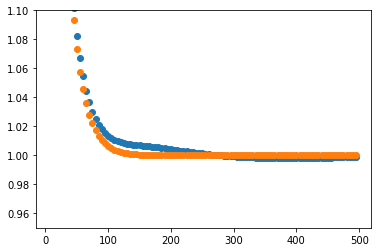

In [6]:
def coeffrecurse(pt,lvl=0):
  if lvl>0:
    return 1.0/(1-np.exp(-0.05*pt*coeffrecurse(pt,lvl-1)))
  else:
    return 1.0

pts = np.asarray([x for x in range(10,500,5)], dtype=float)
ptst = pttrans.transform(pts)
NRep = pts.shape[0]
predm10 = simpuru.predict(tf.stack([ptst,NRep*[-1.0]],1))
predm05 = simpuru.predict(tf.stack([ptst,NRep*[-0.5]],1))
predpm0 = simpuru.predict(tf.stack([ptst,NRep*[ 0.0]],1))
predp05 = simpuru.predict(tf.stack([ptst,NRep*[ 0.5]],1))
predp10 = simpuru.predict(tf.stack([ptst,NRep*[ 1.0]],1))

comp = np.asarray([coeffrecurse(x,10) for x in range(10,500,5)], dtype=float)

plt.scatter(pts,predpm0)
plt.scatter(pts,comp)
plt.ylim(.95, 1.1)

# make predictions for the input data
x_plot = pts
y_plot = comp
yhat_plot = predpm0
# report model error
print('MSE: %.10f' % mean_squared_error(y_plot, yhat_plot))

sdata = pd.DataFrame({'pt': x_plot.tolist(),
                      'corr': y_plot.tolist(),
                      'type': len(x_plot.tolist())*["Correct"]})
tdatapm0 = pd.DataFrame({'pt': x_plot.tolist(),
                         'corr': predm05.tolist(),
                         'type': len(x_plot.tolist())*["Prediction 0"]})
tdatam05 = pd.DataFrame({'pt': x_plot.tolist(),
                         'corr': predm10.tolist(),
                         'type': len(x_plot.tolist())*["Prediction -pi/2"]})
tdatam10 = pd.DataFrame({'pt': x_plot.tolist(),
                         'corr': predpm0.tolist(),
                         'type': len(x_plot.tolist())*["Prediction -pi"]})
tdatap05 = pd.DataFrame({'pt': x_plot.tolist(),
                         'corr': predp05.tolist(),
                         'type': len(x_plot.tolist())*["Prediction  pi/2"]})
tdatap10 = pd.DataFrame({'pt': x_plot.tolist(),
                         'corr': predp10.tolist(),
                         'type': len(x_plot.tolist())*["Prediction  pi"]})
alldata = pd.concat([sdata,tdatapm0,tdatam05,tdatap05,tdatam10,tdatap10])
alt.Chart(alldata).mark_point().encode(
    x=alt.X('pt:Q',scale=alt.Scale(domain=[20, 500])),
    y=alt.Y('corr:Q',scale=alt.Scale(domain=[0.95, 1.4])),
    color='type:N', 
    tooltip=['type','pt','corr']
    ).properties(width=1500,height=500).interactive()

In [41]:
coeffrecurse(50,4)

12.718774616794509